# Preprocess Data

In [1]:
# load data csv
import pandas as pd

data_folder = 'data/'

drive_log = pd.read_csv(data_folder + 'driving_log.csv')
drive_log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


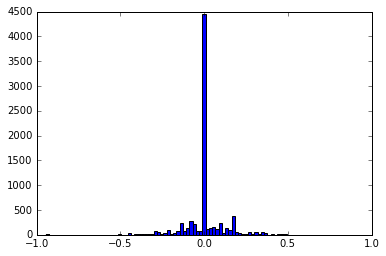

In [2]:
# plot the distribution
import matplotlib.pyplot as plt

plt.hist(drive_log['steering'], bins=100)
plt.show()

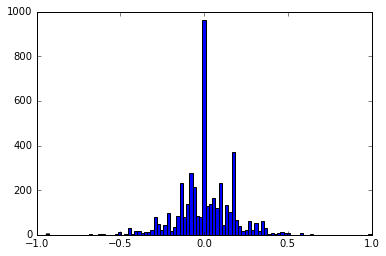

In [3]:
# only use 20% of data with steering == 0, since data is too skewed

drive_log = drive_log[drive_log['steering'] != 0].append(drive_log[drive_log['steering'] == 0].sample(frac=0.2))
plt.hist(drive_log['steering'], bins=100)
plt.show()

/home/cthesky/miniconda3/envs/tf/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


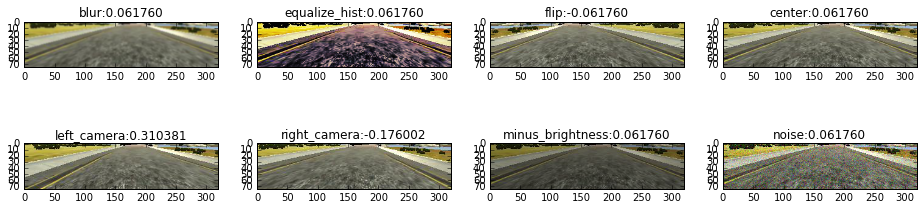

In [6]:
# Define and visualize the data argumentation

import numpy as np
from skimage import io, color, exposure, filters, img_as_ubyte
from skimage.transform import resize
from skimage.util import random_noise

def generate_data(line):
    type2data = {}
    
    # center image
    center_img = io.imread(data_folder + line['center'].strip())
    center_ang = line['steering']
    type2data['center'] = (center_img, center_ang)
    
    # flip image if steering is not 0
    if line['steering']:
        flip_img = center_img[:, ::-1]
        flip_ang = center_ang * -1
        type2data['flip'] = (flip_img, flip_ang)
    
    # left image 
    left_img = io.imread(data_folder + line['left'].strip())
    left_ang = center_ang + .2+ .05 * np.random.random()
    left_ang = min(left_ang, 1)
    type2data['left_camera'] = (left_img, left_ang)
    
    # right image
    right_img = io.imread(data_folder + line['right'].strip())
    right_ang = center_ang - .2 - .05 * np.random.random()
    right_ang = max(right_ang, -1)
    type2data['right_camera'] = (right_img, right_ang)
    
    # minus brightness
    aug_img = color.rgb2hsv(center_img)
    aug_img[:, :, 2] *= .5 + .4 * np.random.uniform()
    aug_img = img_as_ubyte(color.hsv2rgb(aug_img))
    aug_ang = center_ang
    type2data['minus_brightness'] = (aug_img, aug_ang)
    
    # equalize_hist
    aug_img = np.copy(center_img)
    for channel in range(aug_img.shape[2]):
        aug_img[:, :, channel] = exposure.equalize_hist(aug_img[:, :, channel]) * 255
    aug_ang = center_ang
    type2data['equalize_hist'] = (aug_img, aug_ang)
    
    # blur image
    blur_img = img_as_ubyte(np.clip(filters.gaussian(center_img, multichannel=True), -1, 1))
    blur_ang = center_ang
    type2data['blur'] = (blur_img, blur_ang)
    
    # noise image
    noise_img = img_as_ubyte(random_noise(center_img, mode='gaussian'))
    noise_ang = center_ang
    type2data['noise'] = (noise_img, noise_ang)
    
    # crop all images
    for name, (img, ang) in type2data.items():
        img = img[60: -25, ...]
        type2data[name] = (img, ang)
    
    return type2data

def show_data(type2data):
    col = 4
    row = 1 + len(type2data) // 4
    
    f, axarr = plt.subplots(2, col, figsize=(16, 4))

    for idx, (name, (img, ang)) in enumerate(type2data.items()):
        axarr[idx//col, idx%col].set_title('{}:{:f}'.format(name, ang))
        axarr[idx//col, idx%col].imshow(img)

    plt.show()

type2data = generate_data(drive_log.iloc[0])
show_data(type2data)

In [7]:
# Generate all rows of data
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    X_train, y_train = [], []
    for idx, row in drive_log.iterrows():
        type2data = generate_data(row)
        for img, ang in type2data.values():
            X_train.append(img)
            y_train.append(ang)

X_train = np.array(X_train)
y_train = np.array(y_train)

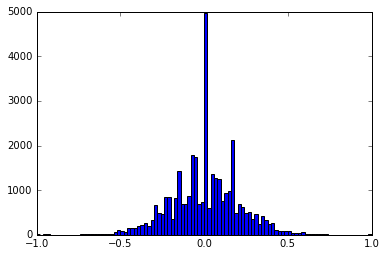

In [9]:
# plot the distribution, tried distribution more uniform but doesn't work well

plt.hist(y_train, bins=100)
plt.show()

In [17]:
# won't use keras fit generator since it's only 2.39 gb 
import sys

gb = (sys.getsizeof(X_train) + sys.getsizeof(y_train)) / 2**30
print('size: {:f} GB'.format(gb))

size: 2.380993 GB


In [18]:
# save training data
np.save('X_train', X_train)
np.save('y_train', y_train)